Running Dynamic Pruning with Multiple Seeds...

=== Running with seed 42 ===


100%|██████████| 170M/170M [00:04<00:00, 41.2MB/s]


Epoch: 1/200 | Train Loss: 3.1582, Train Acc: 17.90% | Val Loss: 2.0865, Val Acc: 25.53% | Sparsity: 0.004
Epoch: 21/200 | Train Loss: 1.0536, Train Acc: 75.76% | Val Loss: 1.1362, Val Acc: 71.71% | Sparsity: 0.079
Epoch: 41/200 | Train Loss: 0.9637, Train Acc: 79.73% | Val Loss: 1.1473, Val Acc: 71.62% | Sparsity: 0.154
Epoch: 61/200 | Train Loss: 0.9147, Train Acc: 81.87% | Val Loss: 1.0197, Val Acc: 77.53% | Sparsity: 0.229
Epoch: 81/200 | Train Loss: 0.8723, Train Acc: 83.69% | Val Loss: 0.9710, Val Acc: 79.73% | Sparsity: 0.304
Epoch: 101/200 | Train Loss: 0.8170, Train Acc: 86.13% | Val Loss: 0.9698, Val Acc: 79.91% | Sparsity: 0.379
Epoch: 121/200 | Train Loss: 0.7574, Train Acc: 88.89% | Val Loss: 0.8725, Val Acc: 83.73% | Sparsity: 0.454
Epoch: 141/200 | Train Loss: 0.6913, Train Acc: 91.71% | Val Loss: 0.7803, Val Acc: 87.55% | Sparsity: 0.529
Epoch: 161/200 | Train Loss: 0.6161, Train Acc: 95.14% | Val Loss: 0.7248, Val Acc: 90.05% | Sparsity: 0.604
Epoch: 181/200 | Train Lo

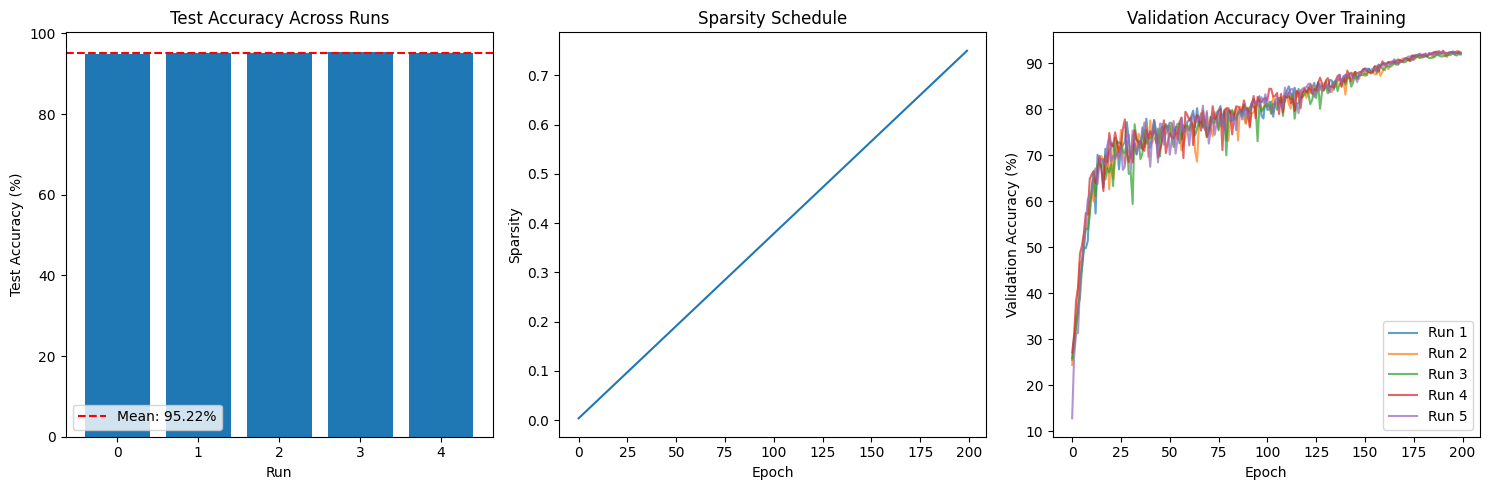

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PDF downloaded successfully


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt
from collections import defaultdict

# Define the basic block for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define ResNet with mask application
class DynamicSparseResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(DynamicSparseResNet, self).__init__()
        self.in_planes = 64
        self.masks = {}  # Store masks for each layer

        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        strides = [stride] + [1] * (num_blocks - 1)
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def apply_masks(self):
        """Apply masks to weights during forward pass"""
        if not hasattr(self, 'masks') or not self.masks:
            return
        with torch.no_grad():
            for name, param in self.named_parameters():
                mask = self.masks.get(name, None)
                if mask is not None:
                    param.mul_(mask)

    def forward(self, x):
        # Apply masks before forward pass
        self.apply_masks()

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(num_classes=10):
    return DynamicSparseResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

def apply_dynamic_supermask(model, sparsity_rate):
    """Fixed implementation with no regrowth - once pruned, stays pruned"""
    total_params = 0
    active_mags = []
    metas = []  # (name, param, current_mask)

    # Gather active weights only
    for name, param in model.named_parameters():
        if ('weight' in name) and (param.dim() > 1):
            current_mask = getattr(model, 'masks', {}).get(name, torch.ones_like(param, device=param.device))
            mags = param.detach().abs()
            active_vals = mags[current_mask.bool()]  # Only active entries
            active_mags.append(active_vals)
            metas.append((name, param, current_mask))
            total_params += param.numel()

    if not active_mags:
        return {}, 0.0

    active_cat = torch.cat(active_mags)
    # How many weights should remain nonzero globally at this sparsity
    keep_target = int(round((1.0 - sparsity_rate) * total_params))
    # Clamp to current active count
    keep_k = min(keep_target, active_cat.numel())

    if keep_k <= 0:
        thr = active_cat.max() + 1  # Prune all currently active
    else:
        thr = torch.topk(active_cat, keep_k, largest=True, sorted=True)[0][-1]

    # Build new masks with NO REGROWTH
    masks = {}
    pruned_params = 0
    for name, param, current_mask in metas:
        mags = param.detach().abs()
        new_keep = (mags >= thr).float()
        final_mask = new_keep * current_mask  # Intersect: forbids regrowth
        masks[name] = final_mask
        pruned_params += (final_mask == 0).sum().item()

    actual_sparsity = pruned_params / total_params

    # Store masks in model
    if not hasattr(model, 'masks'):
        model.masks = {}
    model.masks.update(masks)

    return masks, actual_sparsity

def train_with_dynamic_pruning(model, train_loader, val_loader, test_loader, epochs=200, device='cuda', seed=42):
    """Fixed training with proper masking"""
    torch.manual_seed(seed)
    np.random.seed(seed)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    initial_sparsity = 0.0
    final_sparsity = 0.75
    sparsity_increment = (final_sparsity - initial_sparsity) / epochs

    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    sparsity_history = []

    initialize_weights(model)

    # Track training time
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        #current_sparsity = min(final_sparsity, initial_sparsity + sparsity_increment * epoch)
        current_sparsity = min(final_sparsity, initial_sparsity + sparsity_increment * (epoch + 1))
        masks, actual_sparsity = apply_dynamic_supermask(model, current_sparsity)
        sparsity_history.append(actual_sparsity)

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Apply masks to gradients
            for name, param in model.named_parameters():
                if name in masks and param.grad is not None:
                    param.grad.mul_(masks[name])

            optimizer.step()

            # Re-enforce masks post-step to prevent momentum nudging zeros away from zero
            with torch.no_grad():
                for name, param in model.named_parameters():
                    mask = model.masks.get(name, None)
                    if mask is not None:
                        param.mul_(mask)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_accuracy = 100.0 * correct / total

        # Validation
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)

        scheduler.step()

        if epoch % 20 == 0 or epoch == epochs - 1:
            print(
                f"Epoch: {epoch+1}/{epochs} | "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}% | "
                f"Sparsity: {actual_sparsity:.3f}"
            )

    training_time = time.time() - start_time

    # Final evaluation
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

    results = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'sparsity_history': sparsity_history,
        'training_time': training_time,
        'final_sparsity': actual_sparsity
    }

    return results

def evaluate(model, data_loader, criterion, device):
    model.eval()
    loss_total = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss_total += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = loss_total / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

def run_multiple_seeds(seeds=[42, 123, 456, 789, 999], epochs=200):
    """Run experiments with multiple seeds for statistical validation"""
    all_results = []

    for seed in seeds:
        print(f"\n=== Running with seed {seed} ===")

        # Reinitialize data loaders with different seed
        torch.manual_seed(seed)
        np.random.seed(seed)

        # Data setup (same as before)
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.RandomErasing(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        ])

        train_dataset = torchvision.datasets.CIFAR10(
            root='./data', train=True, download=True, transform=transform_train
        )
        test_dataset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=True, transform=transform_test
        )

        train_size = int(0.89 * len(train_dataset))
        val_size = len(train_dataset) - train_size
        train_subset, val_subset = torch.utils.data.random_split(
            train_dataset, [train_size, val_size]
        )

        train_loader = torch.utils.data.DataLoader(
            train_subset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
        )
        val_loader = torch.utils.data.DataLoader(
            val_subset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True
        )
        test_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True
        )

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = ResNet18(num_classes=10).to(device)

        results = train_with_dynamic_pruning(
            model, train_loader, val_loader, test_loader, epochs=epochs, device=device, seed=seed
        )

        all_results.append(results)

        print(f"Seed {seed} - Test Accuracy: {results['test_accuracy']:.2f}%, "
              f"Training Time: {results['training_time']:.1f}s")

    return all_results

def analyze_results(all_results):
    """Analyze results from multiple runs"""
    test_accuracies = [r['test_accuracy'] for r in all_results]
    val_accuracies = [r['val_acc'][-1] for r in all_results]
    training_times = [r['training_time'] for r in all_results]

    print("\n=== Statistical Analysis ===")
    print(f"Test Accuracy: {np.mean(test_accuracies):.2f} ± {np.std(test_accuracies):.2f}%")
    print(f"Val Accuracy: {np.mean(val_accuracies):.2f} ± {np.std(val_accuracies):.2f}%")
    print(f"Training Time: {np.mean(training_times):.1f} ± {np.std(training_times):.1f}s")
    print(f"Range: {np.min(test_accuracies):.2f}% - {np.max(test_accuracies):.2f}%")

    return {
        'test_acc_mean': np.mean(test_accuracies),
        'test_acc_std': np.std(test_accuracies),
        'val_acc_mean': np.mean(val_accuracies),
        'val_acc_std': np.std(val_accuracies),
        'time_mean': np.mean(training_times),
        'time_std': np.std(training_times)
    }

# Simple SNIP baseline for comparison
def snip_pruning(model, data_loader, sparsity_rate, device):
    """SNIP baseline implementation - fixed version"""
    model.train()

    # Get a batch for gradient computation
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)

    # Compute gradients
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=False)

    # Calculate SNIP scores
    scores = []
    for param, grad in zip(model.parameters(), grads):
        if param.dim() > 1:  # Only conv and linear layers
            score = (param * grad).abs().flatten()
            scores.append(score)

    # Global threshold - build once, slice once
    all_scores = torch.cat(scores)
    k = int(all_scores.numel() * (1 - sparsity_rate))
    thr = all_scores.topk(k, largest=True).values[-1] if k > 0 else all_scores.max()

    # Create masks
    masks = {}
    idx = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            n = param.numel()
            ps = all_scores[idx:idx+n].view_as(param)
            masks[name] = (ps >= thr).float()
            idx += n

    return masks

if __name__ == "__main__":
    # Run with multiple seeds for statistical validation
    print("Running Dynamic Pruning with Multiple Seeds...")
    all_results = run_multiple_seeds(seeds=[42, 123, 456, 789, 999], epochs=200)
    stats = analyze_results(all_results)

    # Plot results and save as PDF
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    test_accs = [r['test_accuracy'] for r in all_results]
    plt.bar(range(len(test_accs)), test_accs)
    plt.axhline(y=np.mean(test_accs), color='r', linestyle='--', label=f'Mean: {np.mean(test_accs):.2f}%')
    plt.xlabel('Run')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy Across Runs')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(all_results[0]['sparsity_history'])
    plt.xlabel('Epoch')
    plt.ylabel('Sparsity')
    plt.title('Sparsity Schedule')

    plt.subplot(1, 3, 3)
    for i, result in enumerate(all_results):
        plt.plot(result['val_acc'], alpha=0.7, label=f'Run {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Validation Accuracy Over Training')
    plt.legend()

    plt.tight_layout()

    # Save as PDF (vector format)
    plt.savefig('cifar10_results.pdf', format='pdf', bbox_inches='tight', dpi=300)
    print("Plot saved as cifar10_results.pdf")

    plt.show()

    # Download in Colab
    try:
        from google.colab import files
        files.download('cifar10_results.pdf')
        print("PDF downloaded successfully")
    except ImportError:
        print("Not running in Colab - PDF saved locally")